In [1]:
!mkdir write

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


In [4]:
results_file = 'write/result.h5ad' 

In [5]:
adata = sc.read_10x_mtx(
    'data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)      

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 6272 × 32738
    var: 'gene_ids'

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata

AnnData object with n_obs × n_vars = 6272 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


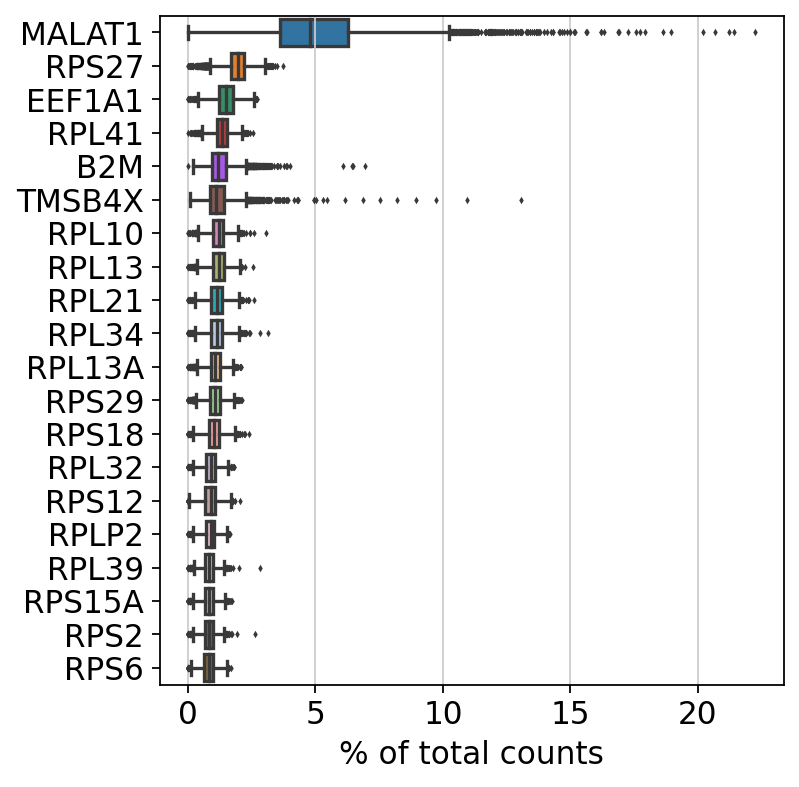

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, save='.png')

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16521 genes that are detected in less than 3 cells


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

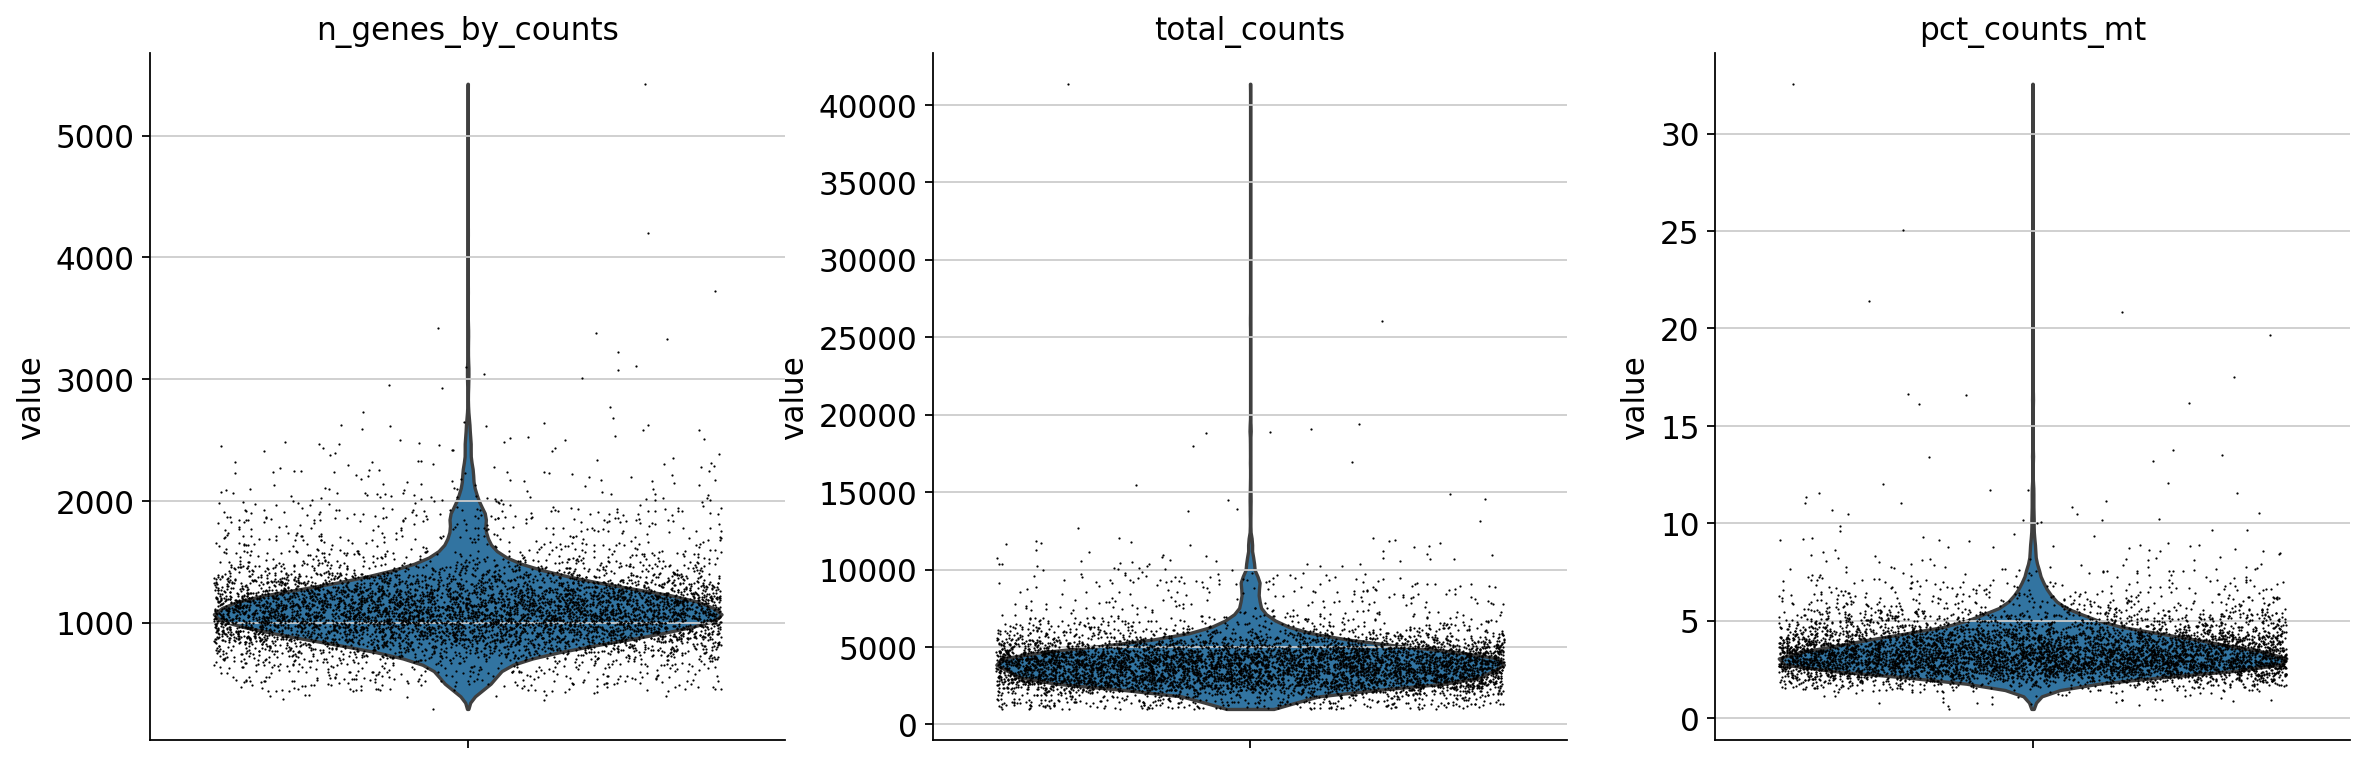

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,save='.png')

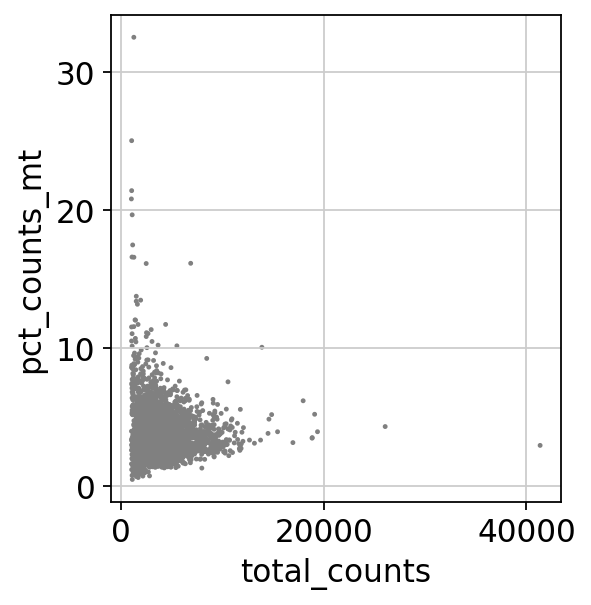

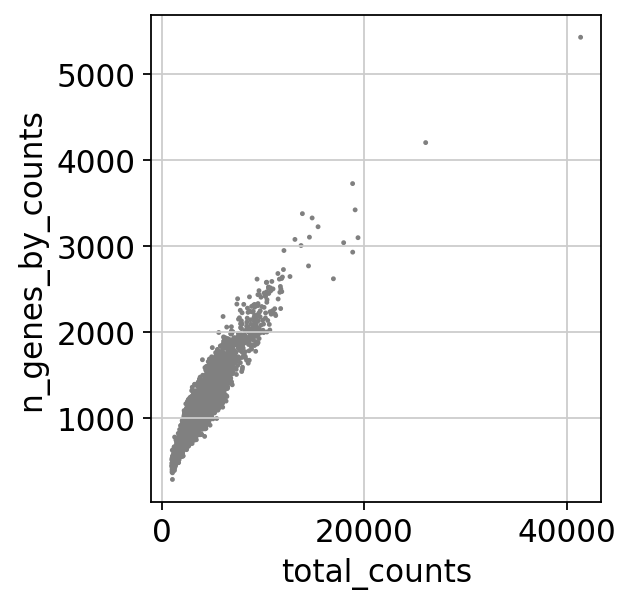

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',save='.png')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='.png')

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/aaron/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


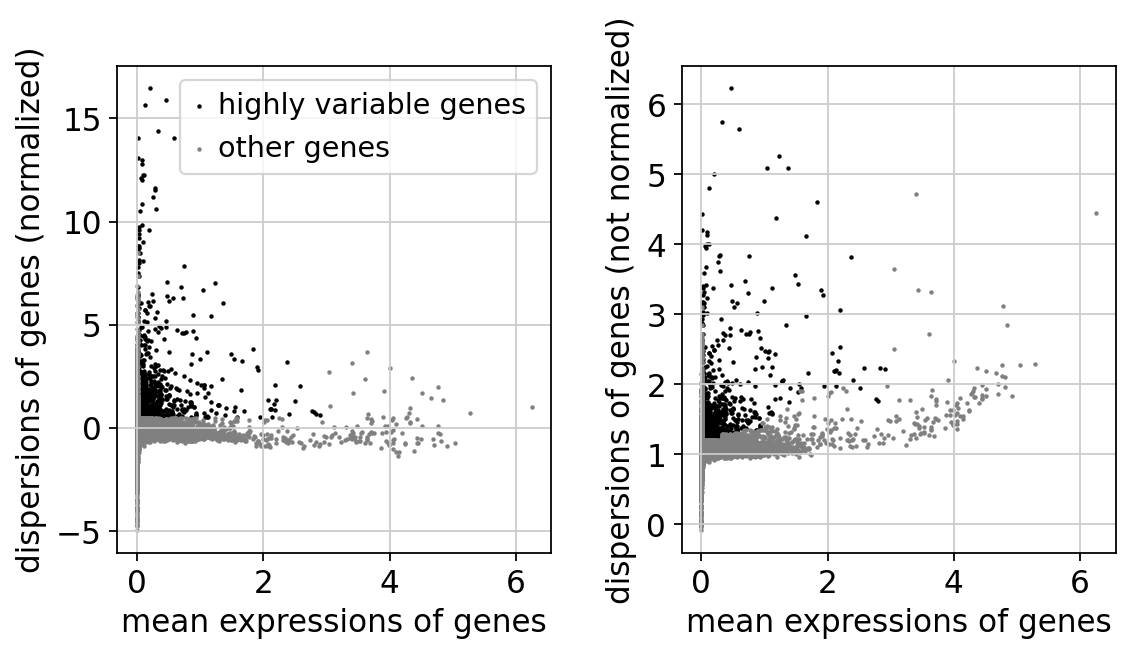

In [18]:
sc.pl.highly_variable_genes(adata,save='.png')

In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


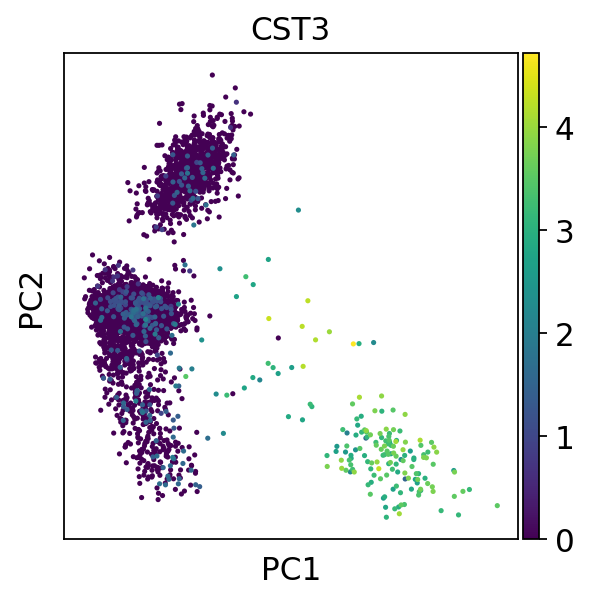

In [24]:
sc.pl.pca(adata, color='CST3',save='.png')

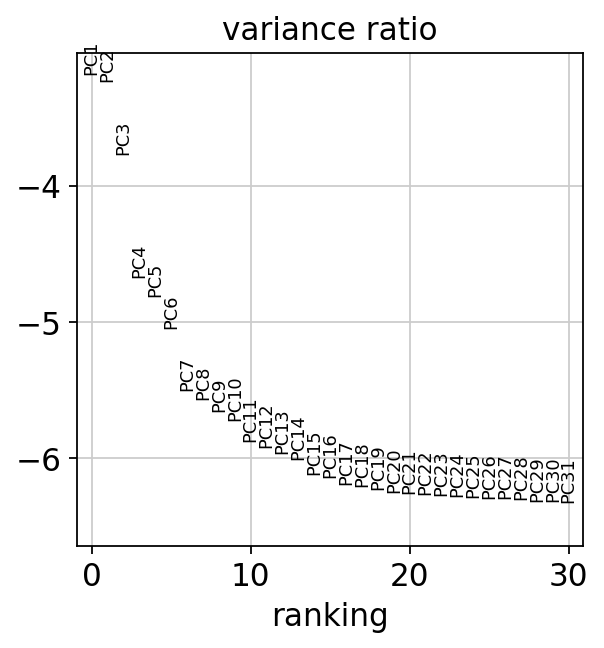

In [25]:
sc.pl.pca_variance_ratio(adata, log=True,save='.png')

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 5559 × 1224
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


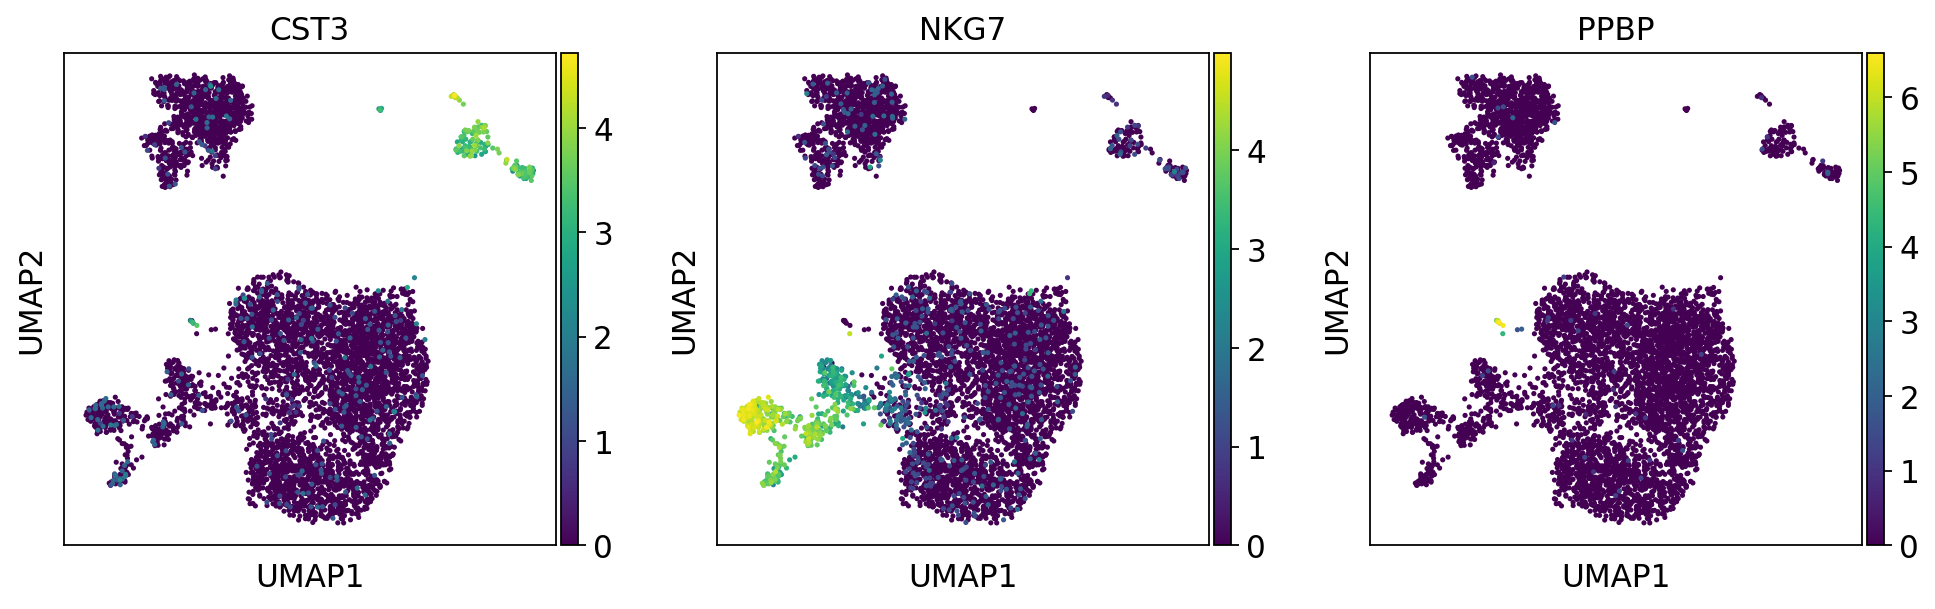

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'],save='.png')

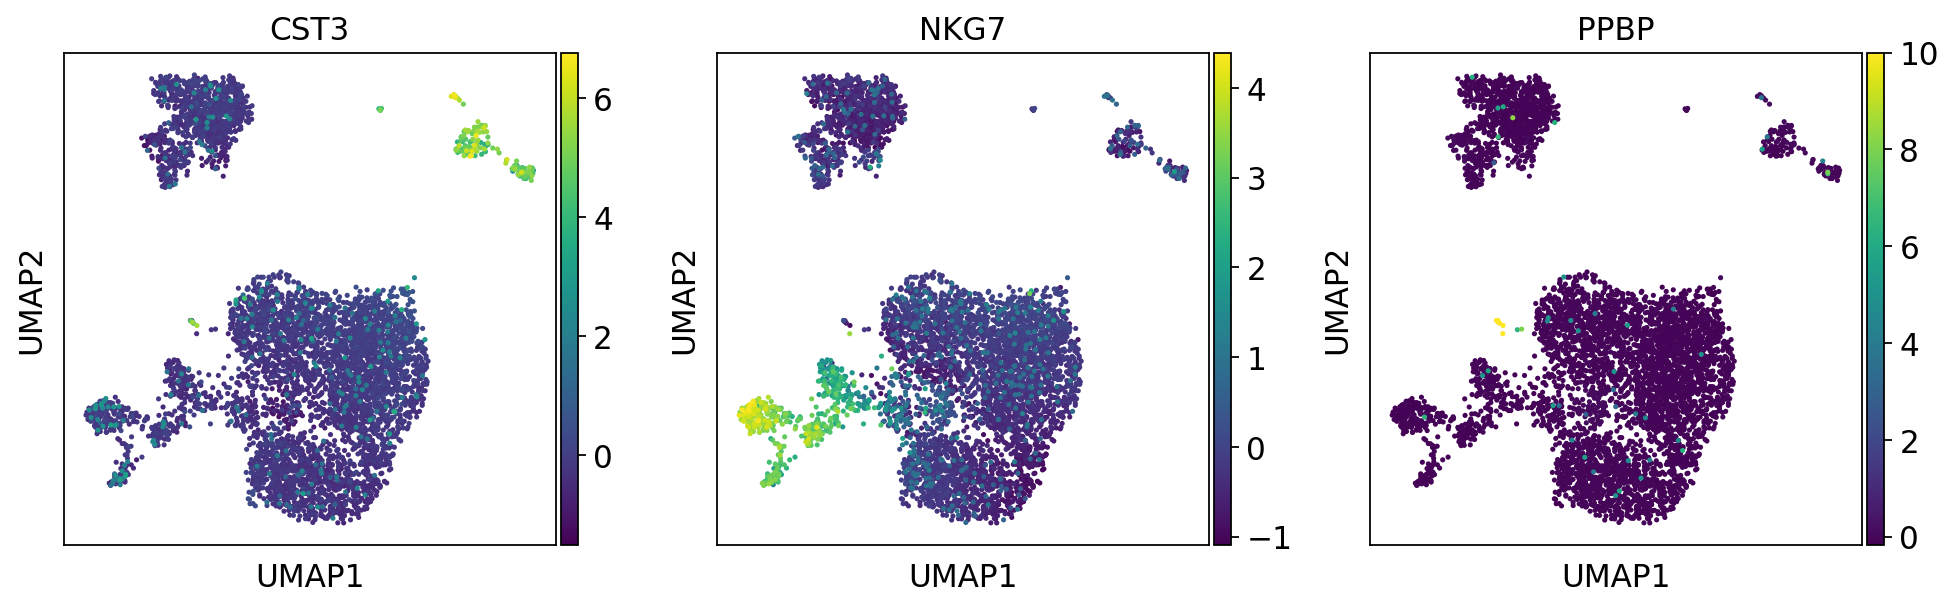

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False,save='.png')

In [32]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


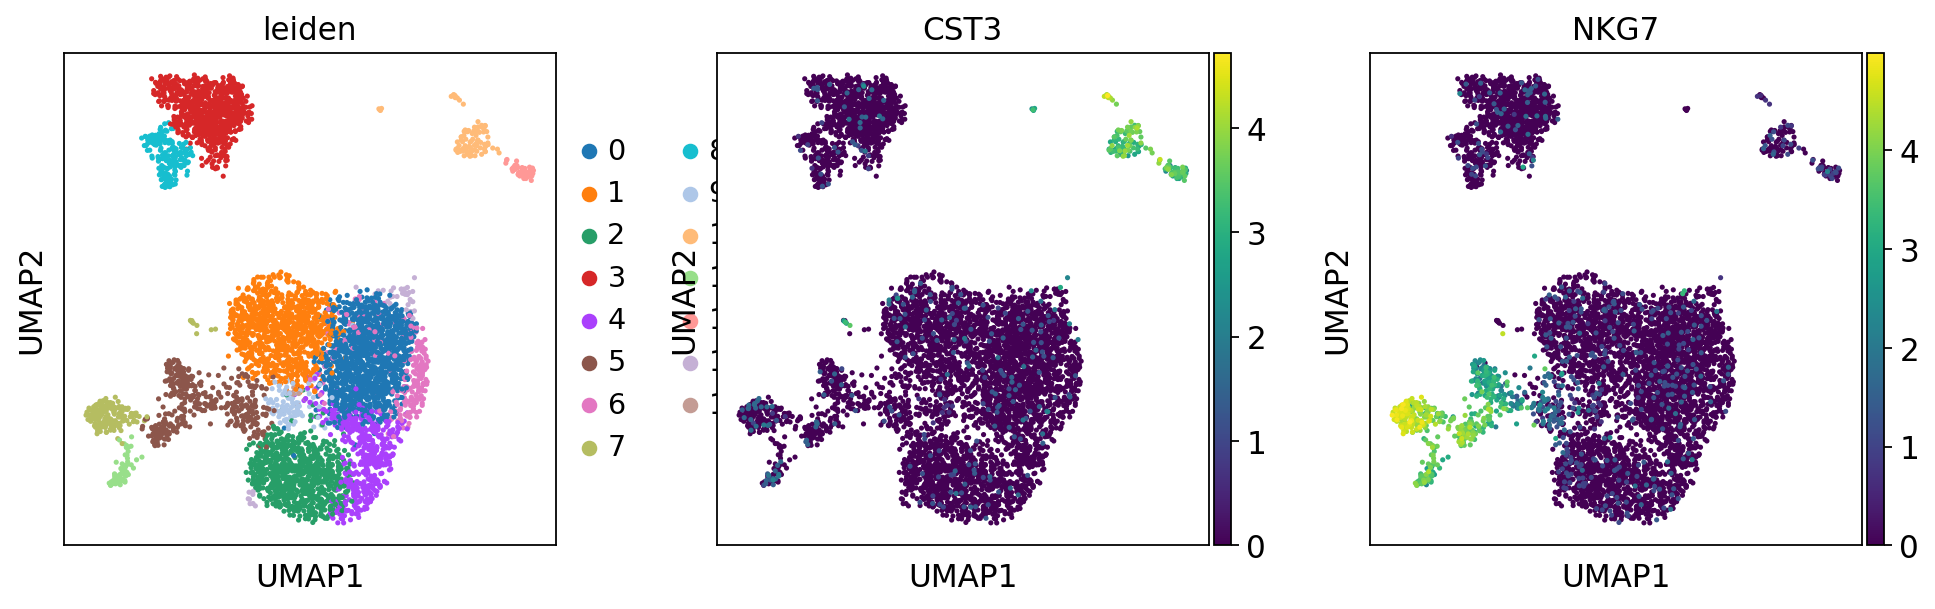

In [33]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'],save='.png')

In [34]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


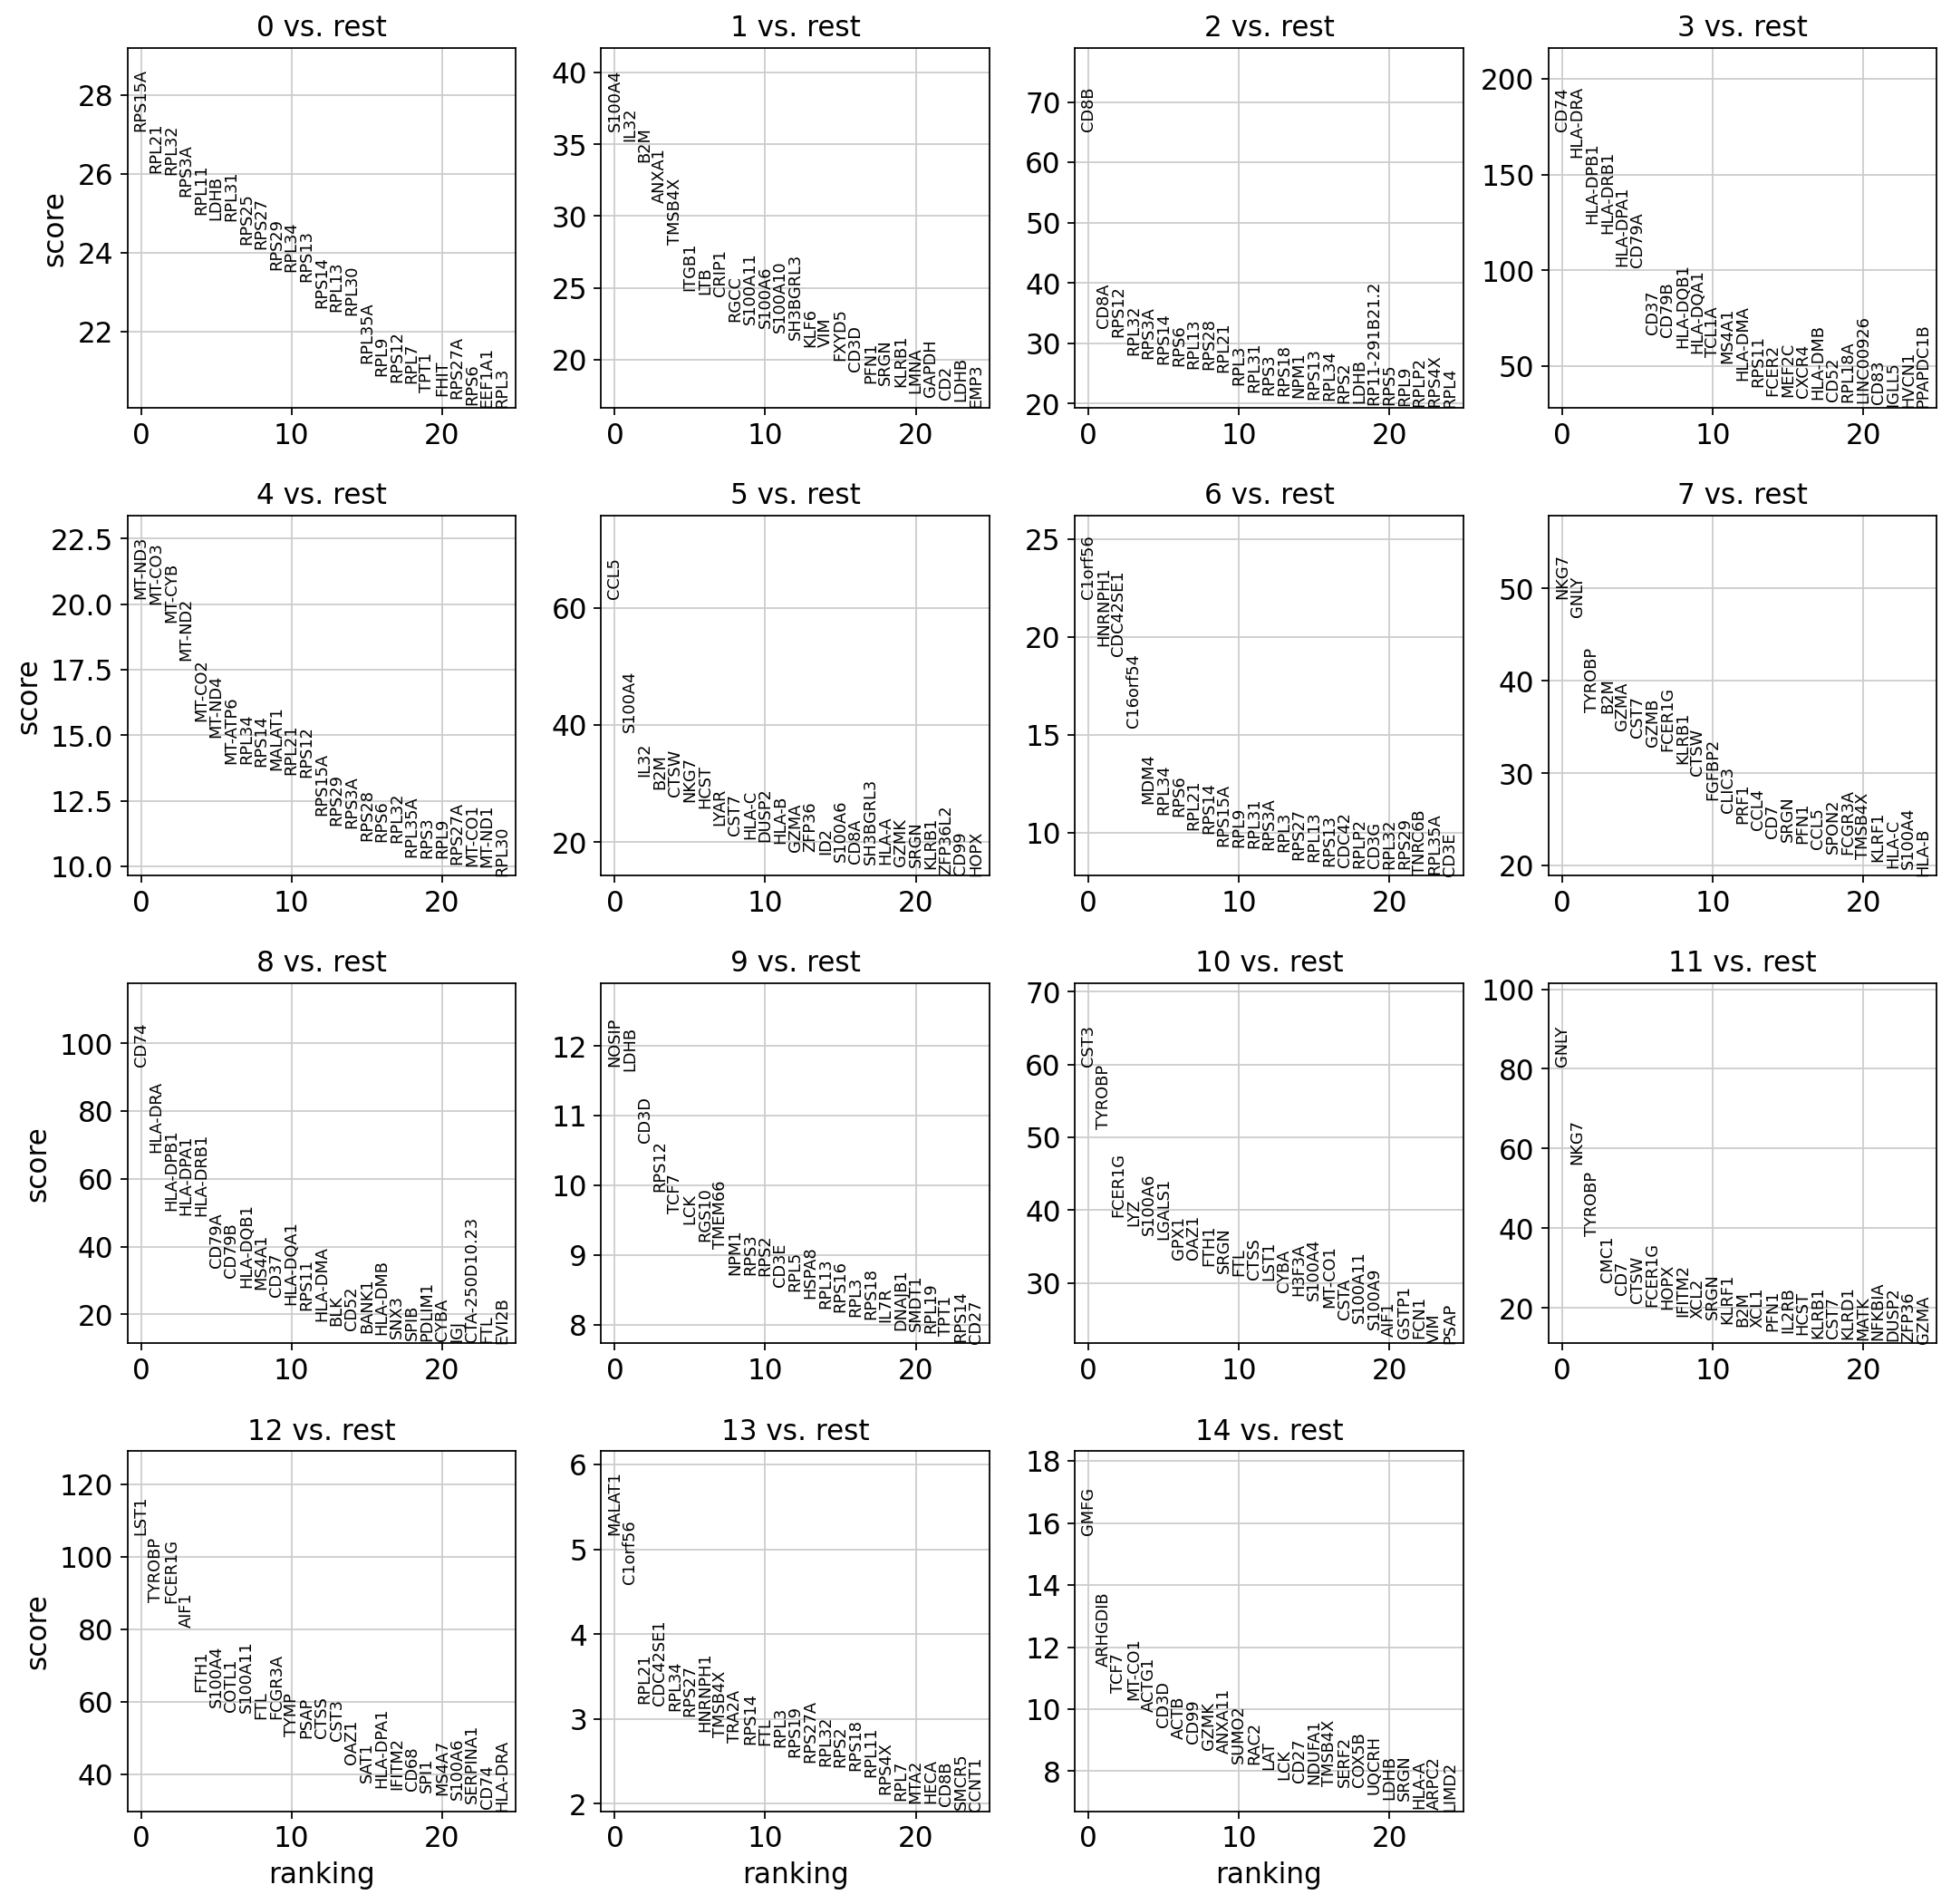

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save='.png')

In [36]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:14)


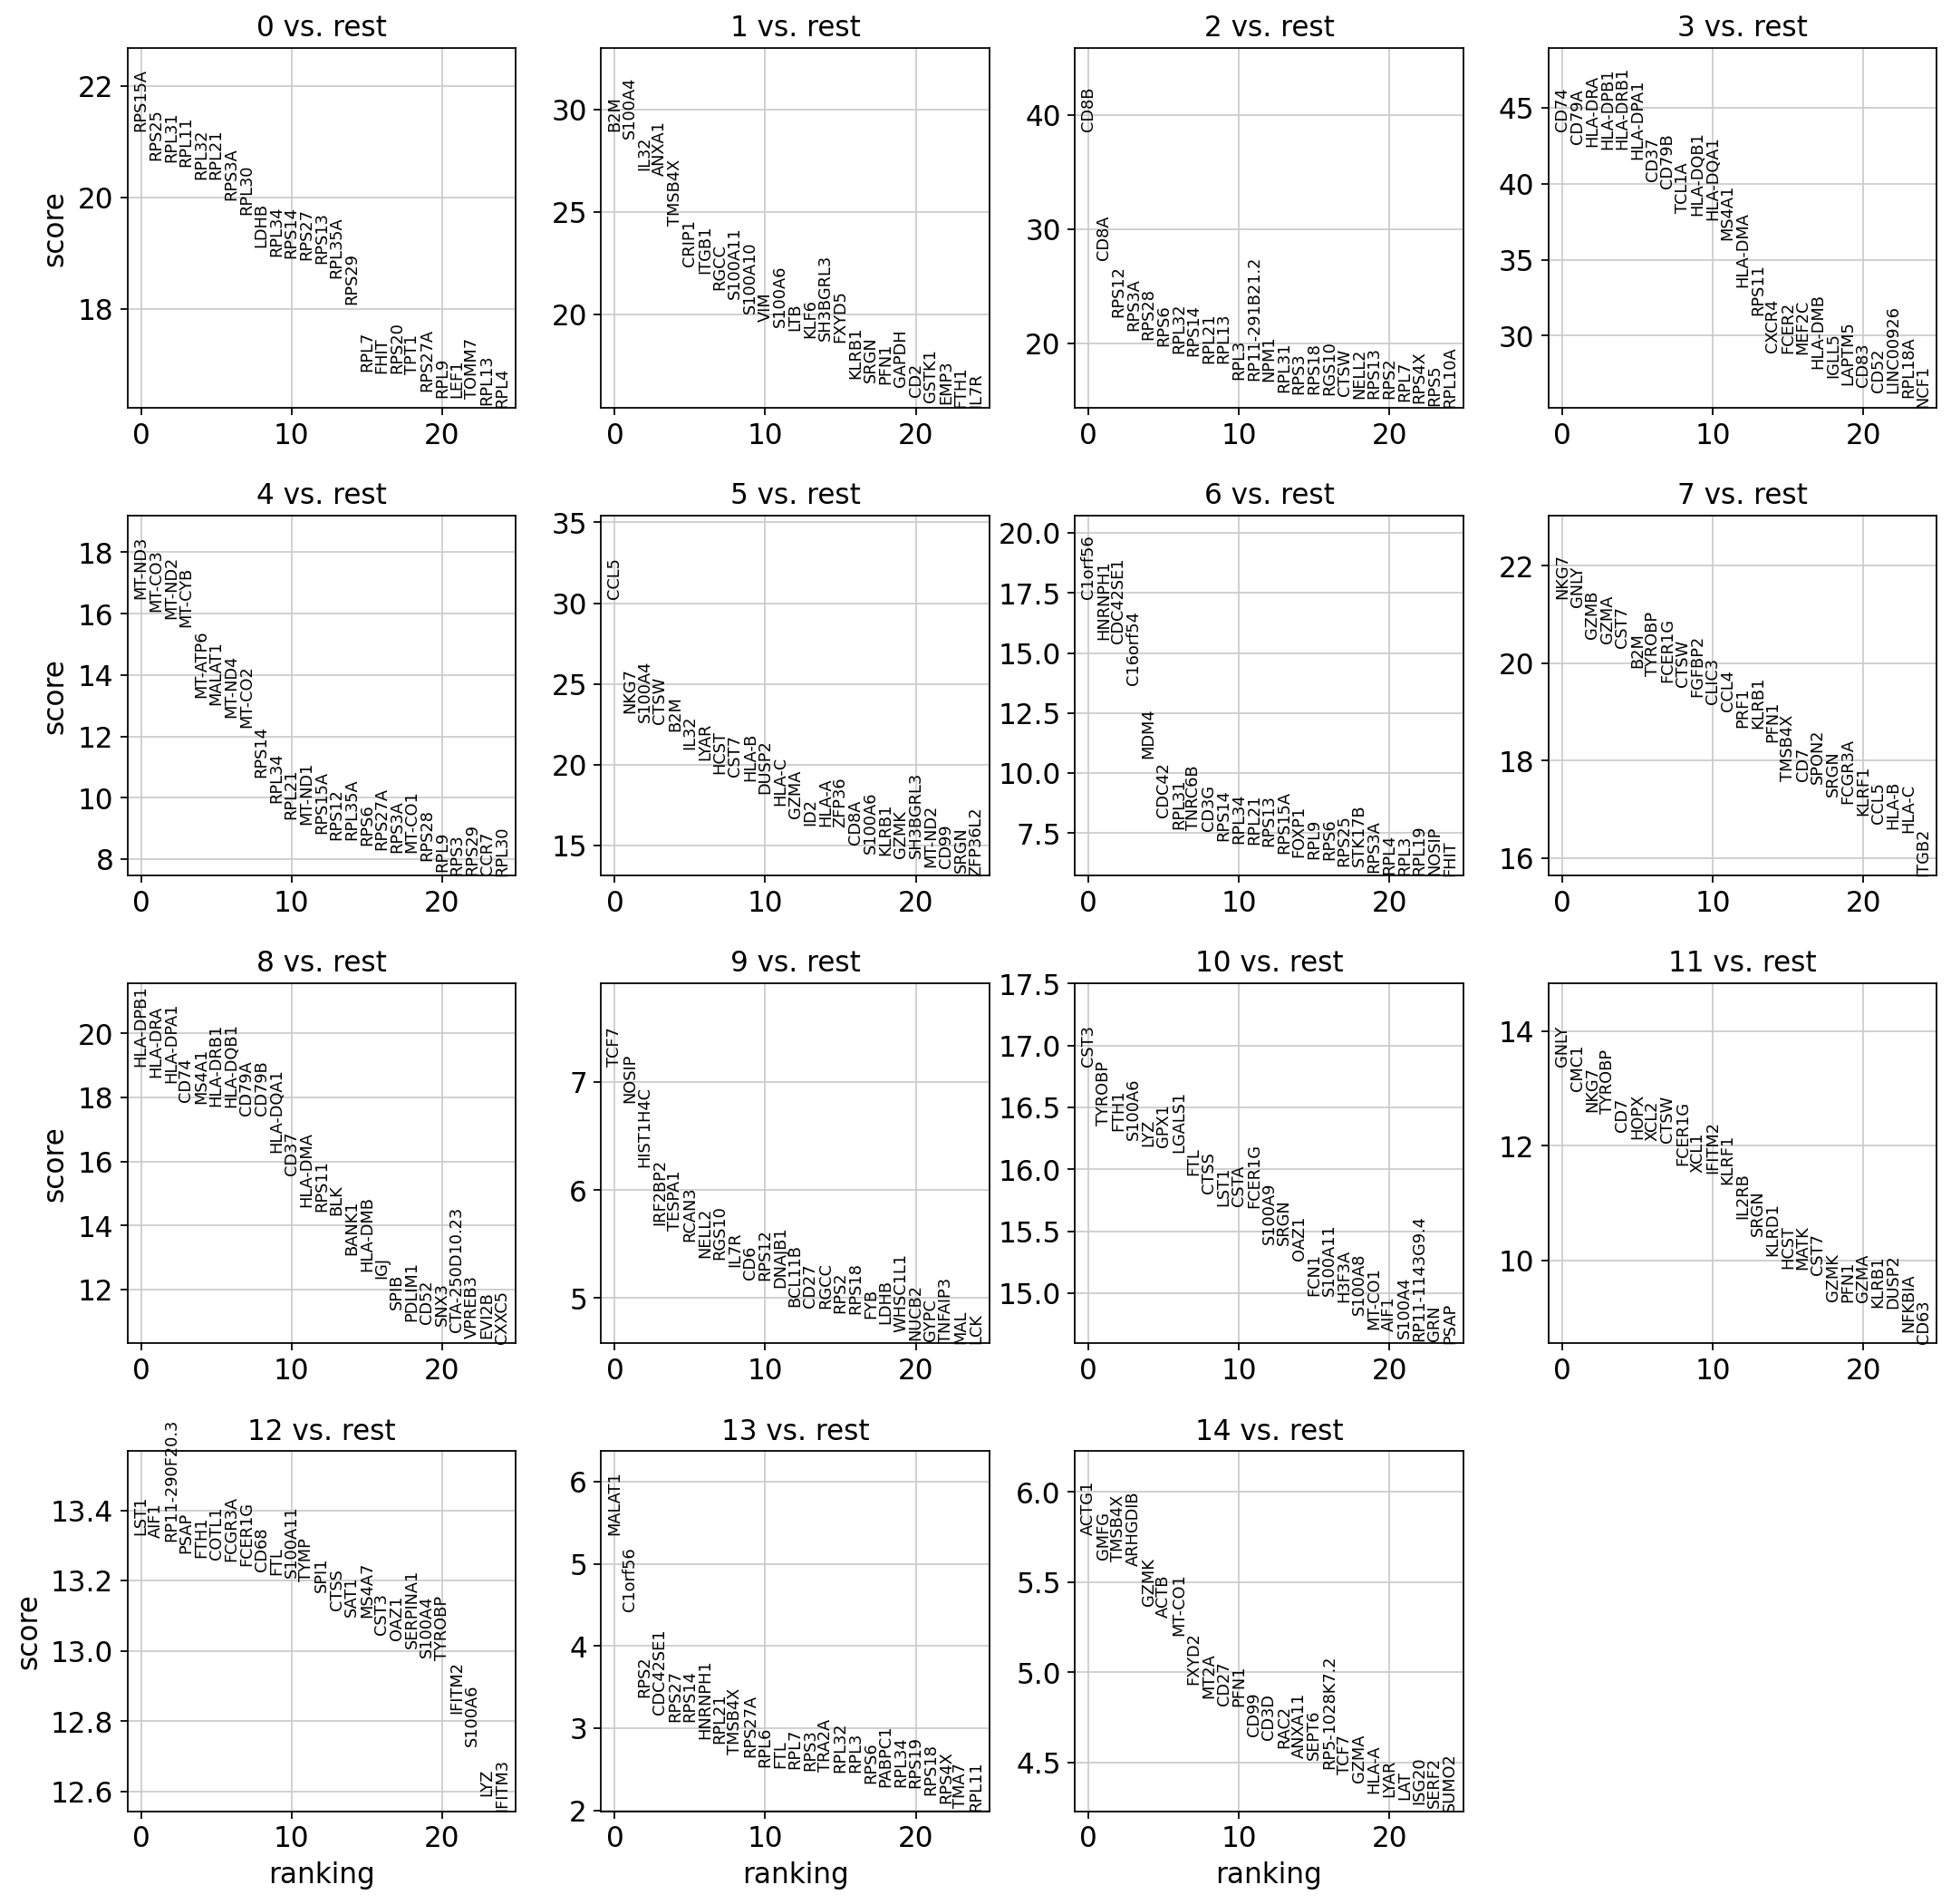

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save='.png')

In [38]:
adata.write(results_file)

ranking genes
    finished (0:00:41)


/home/aaron/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


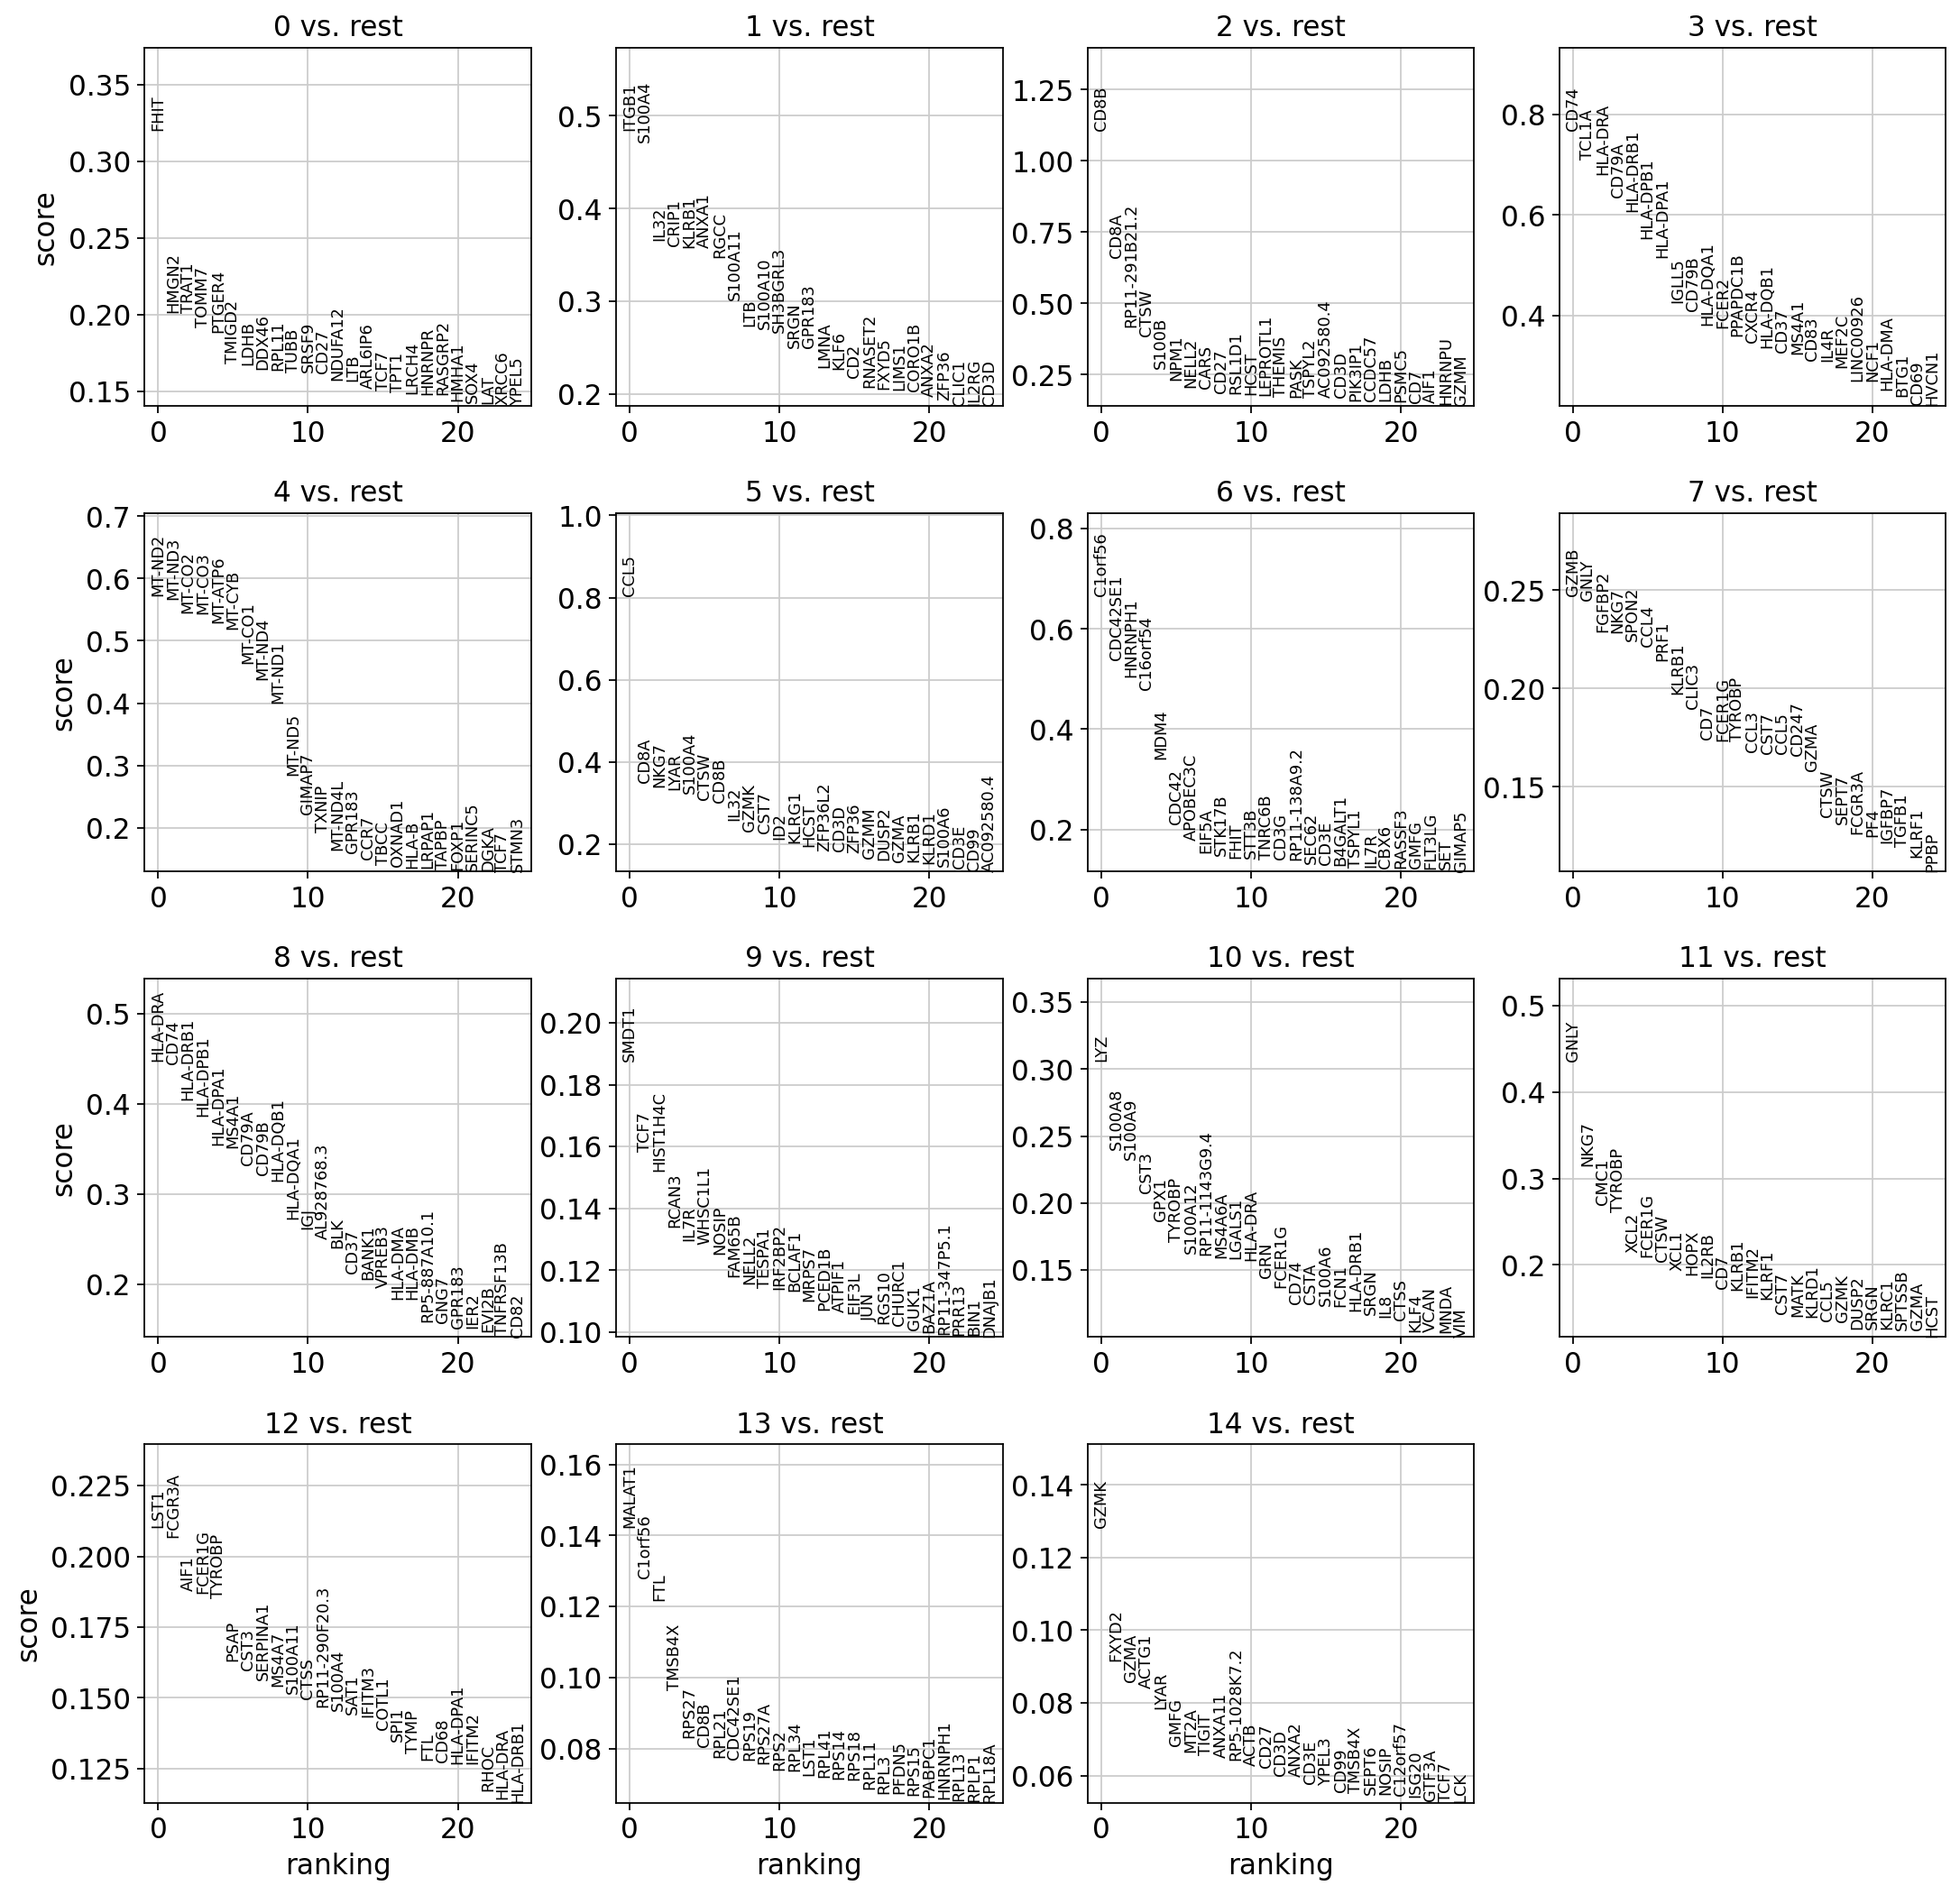

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save='.png')

In [41]:
marker_genes = ["HBB", "PPBP","S100A8","CD14","LYZ","CST3",'CD1C',"FCER1G","FCGR3A","IL7R","CD3E","CD3D","CD8A","CD8B","GZMA","GZMB","GZMH","GZMK", "NKG7", "MS4A1", "CD79A", "MZB1","IGJ",'LILRA4',"IRF7",'IFI44L','ISG15','IFI6']


In [42]:
adata = sc.read(results_file)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0       1      2         3        4       5         6     7         8  \
0  RPS15A     B2M   CD8B      CD74   MT-ND3    CCL5   C1orf56  NKG7  HLA-DPB1   
1   RPS25  S100A4   CD8A     CD79A   MT-CO3    NKG7   HNRNPH1  GNLY   HLA-DRA   
2   RPL31    IL32  RPS12   HLA-DRA   MT-ND2  S100A4  CDC42SE1  GZMB  HLA-DPA1   
3   RPL11   ANXA1  RPS3A  HLA-DPB1   MT-CYB    CTSW  C16orf54  GZMA      CD74   
4   RPL32  TMSB4X  RPS28  HLA-DRB1  MT-ATP6     B2M      MDM4  CST7     MS4A1   

          9      10      11             12        13       14  
0      TCF7    CST3    GNLY           LST1    MALAT1    ACTG1  
1     NOSIP  TYROBP    CMC1           AIF1   C1orf56     GMFG  
2  HIST1H4C    FTH1    NKG7  RP11-290F20.3      RPS2   TMSB4X  
3   IRF2BP2  S100A6  TYROBP           PSAP  CDC42SE1  ARHGDIB  
4    TESPA1     LYZ     CD7           FTH1     RPS27     GZMK

In [44]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p     1_n            1_p    2_n            2_p  \
0  RPS15A  1.113098e-99     B2M  2.912116e-184   CD8B   0.000000e+00   
1   RPS25  6.608006e-95  S100A4  1.151773e-179   CD8A  1.894574e-164   
2   RPL31  1.094901e-94    IL32  4.326471e-161  RPS12  3.426596e-110   
3   RPL11  6.654593e-94   ANXA1  1.033209e-157  RPS3A   4.339628e-99   
4   RPL32  6.407157e-92  TMSB4X  5.781803e-131  RPS28   5.488040e-92   

        3_n  3_p      4_n           4_p  ...    10_n          10_p    11_n  \
0      CD74  0.0   MT-ND3  4.772901e-61  ...    CST3  1.470758e-63    GNLY   
1     CD79A  0.0   MT-CO3  3.587443e-58  ...  TYROBP  3.754461e-60    CMC1   
2   HLA-DRA  0.0   MT-ND2  1.938421e-56  ...    FTH1  8.227597e-60    NKG7   
3  HLA-DPB1  0.0   MT-CYB  1.070235e-54  ...  S100A6  2.812641e-59  TYROBP   
4  HLA-DRB1  0.0  MT-ATP6  2.963196e-40  ...     LYZ  6.442051e-59     CD7   

           11_p           12_n          12_p      13_n          13_p     14_n  \
0  7.505354e-41           LST1  1.520881e-40    MALAT1  8.356822e-08    ACTG1   
1  2.004984e-38           AIF1  1.745314e-40   C1orf56  9.464047e-06     GMFG   
2  2.160063e-36  RP11-290F20.3  1.961881e-40      RPS2  7.164836e-04   TMSB4X   
3  2.959829e-36           PSAP  3.116477e-40  CDC42SE1  1.516936e-03  ARHGDIB   
4  1.538066e-34           FTH1  3.664226e-40     RPS27  2.101131e-03     GZMK   

           14_p  
0  8.173683e-09  
1  1.845267e-08  
2  1.953136e-08  
3  2.238063e-08  
4  7.805356e-08  

[5 rows x 30 columns]

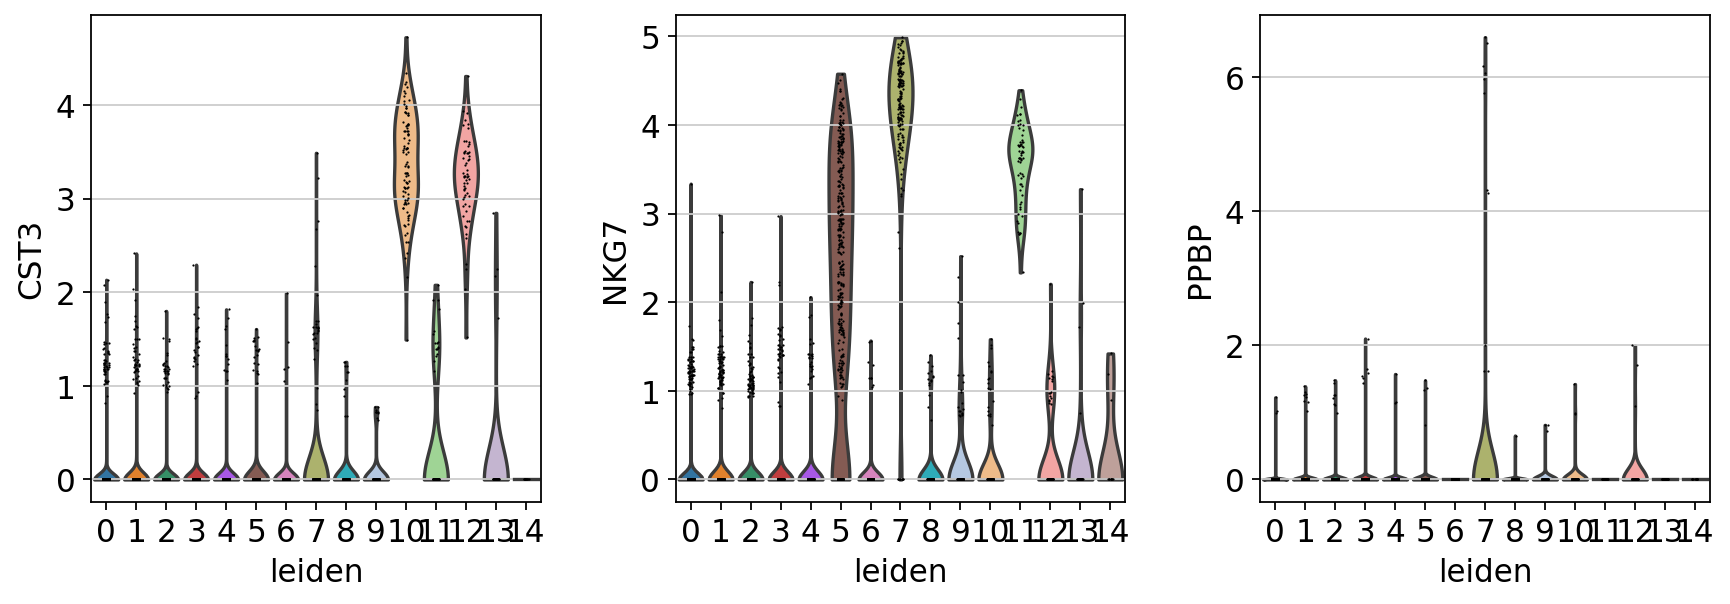

In [45]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

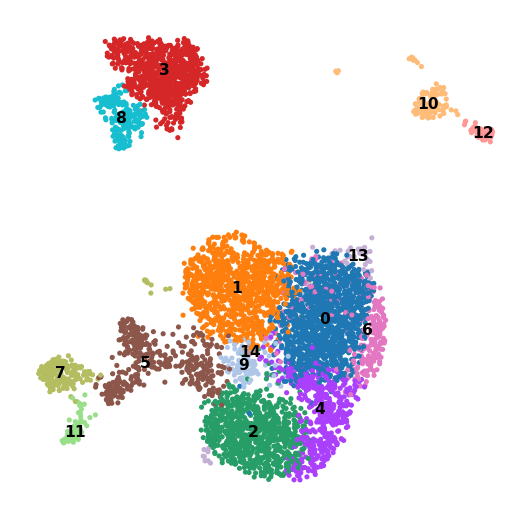

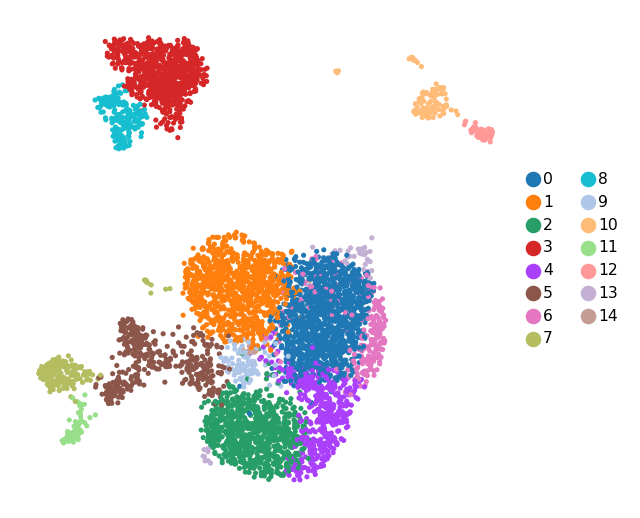

In [46]:
sc.pl.umap(adata, color='leiden', legend_loc='on data',legend_fontsize=7,  title='', frameon=False, save='.png')
sc.pl.umap(adata, color='leiden',legend_fontsize=7,  title='', frameon=False, save='umap2.png')


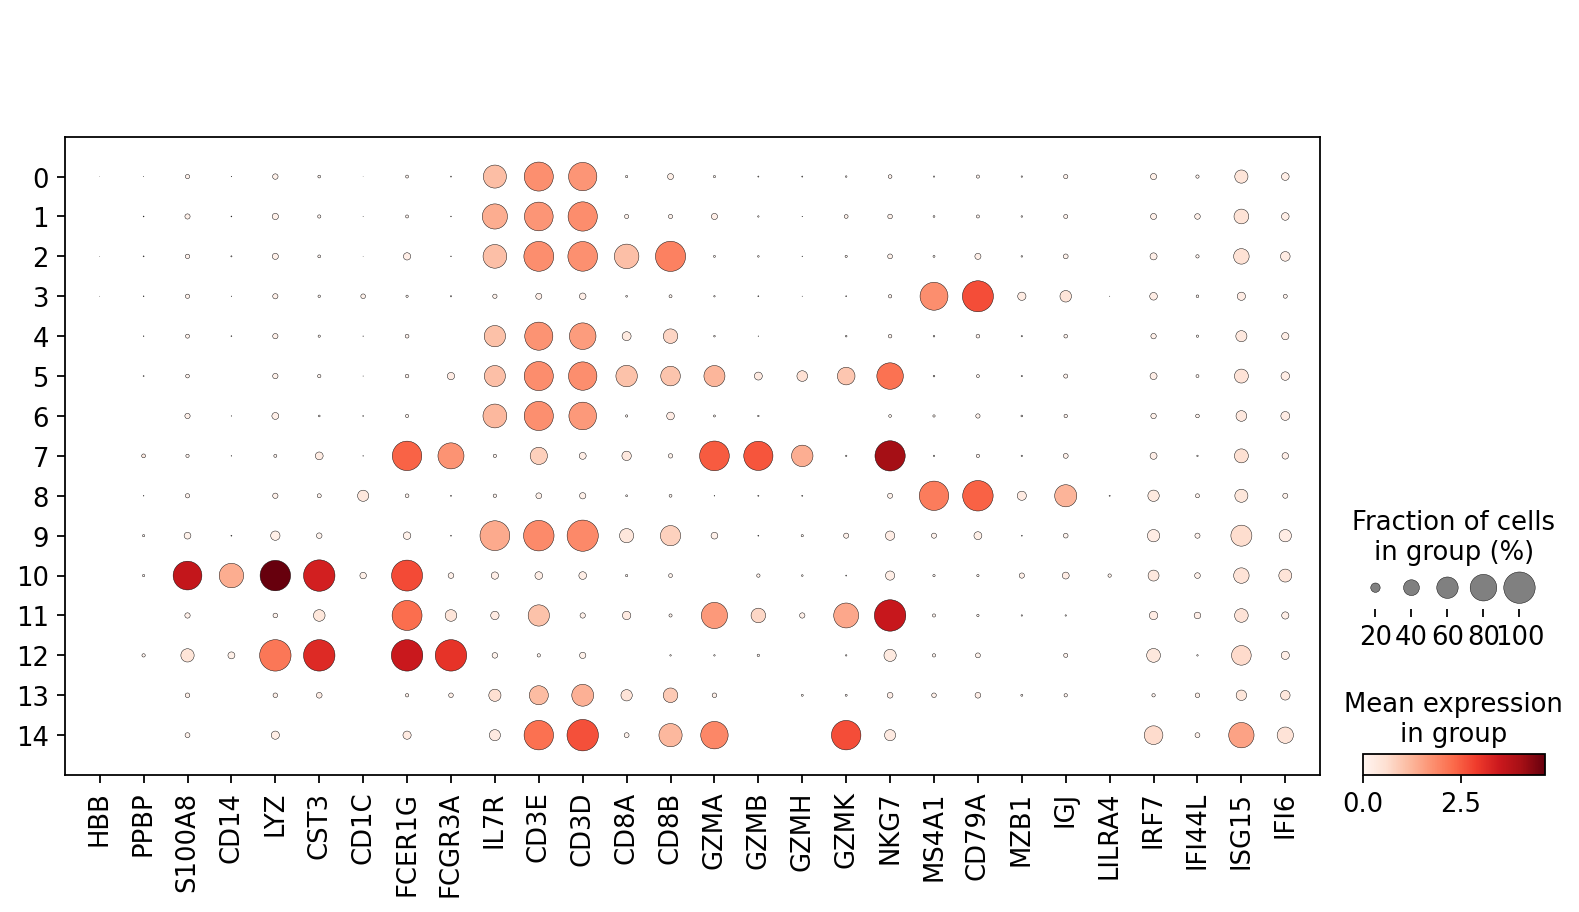

In [47]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', save='.png');

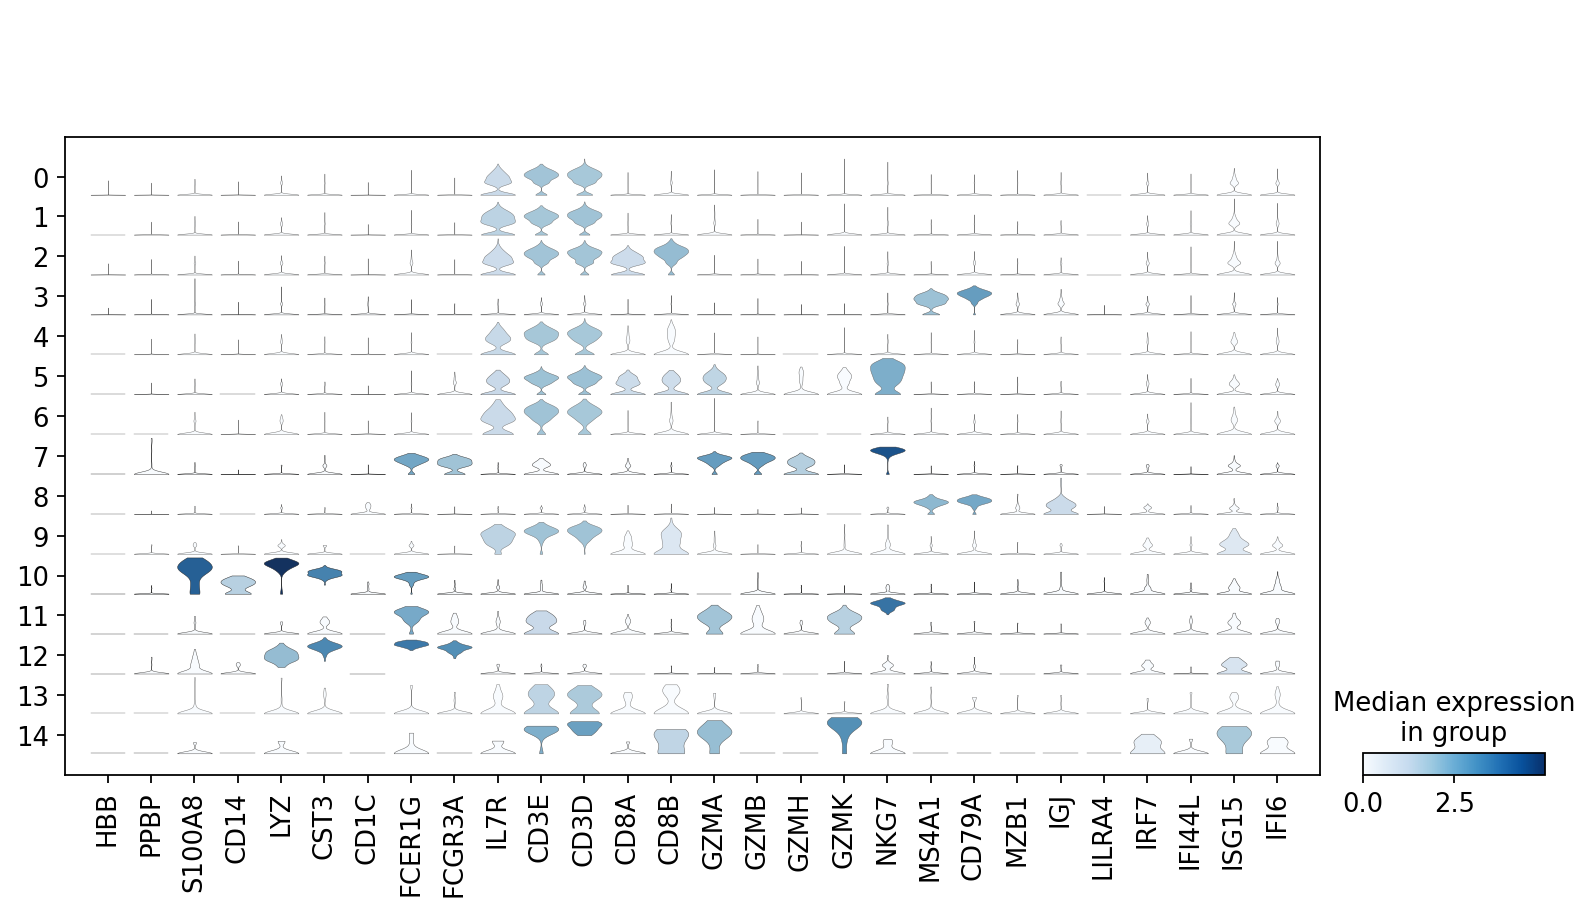

In [48]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90, save='.png');

In [49]:
adata

AnnData object with n_obs × n_vars = 5559 × 1224
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [50]:
adata.write(results_file, compression='gzip') 

In [51]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [52]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )